# Introduction

Fill

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib
import clearsky_detect_model_free
import preprocess

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

import warnings

%load_ext autoreload
%autoreload 2

# Setup

## Load data

Weather and performance data are taken at 1min intervals.  Supplier is the Sandia National Lab Regional Test Center in Albuquerque, NM.  Data spans roughly 2016-April 2017.  This data was scraped from PVDAQ (http://bit.ly/2mKrOwG).  The meteorological data and the performance data are contained in two separate files (technically separate systems - PV system and meteorological station).

In [2]:
def load_snl():
    filename = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
    cols = ['Global_Wm2', 'Date-Time']
    data = pd.read_csv(filename, parse_dates=['Date-Time'], usecols=cols, index_col=['Date-Time'])
    data.index = data.index.tz_localize('Etc/GMT+7')
    data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq='1min')).fillna(0)
    data = pd.Series(data['Global_Wm2'], index=data.index)
    data[data < 0] = 0 
    return data

In [3]:
def load_srrl():
    srrl_file = os.path.expanduser('~/data_sets/srrl/20140101.csv')
    srrl_data = pd.read_csv(srrl_file)
    srrl_data.index = pd.to_datetime(srrl_data['DATE (MM/DD/YYYY)'] + ' ' + srrl_data['MST'])
    srrl_data.index = srrl_data.index.tz_localize('Etc/GMT+7')
    srrl_data = srrl_data[~srrl_data.index.duplicated(keep='first')]
    # srrl_data = srrl_data.reindex(
    #     pd.date_range(start=srrl_data.index[0], end=srrl_data.index[-1], freq='1min')
    # ).fillna(0)
    srrl_data.drop(['DATE (MM/DD/YYYY)', 'MST'], inplace=True, axis=1)
    srrl_data = pd.Series(srrl_data['Global 40-South LI-200 [W/m^2]'], index=srrl_data.index)
    srrl_data[srrl_data < 0] = 0
    srrl_data2 = pd.Series(0, index=pd.date_range(start=srrl_data.index.date[0], end=srrl_data.index.date[-1] + pd.Timedelta('1D'), freq='1min'))
    srrl_data2.index = srrl_data2.index.tz_localize('Etc/GMT+7')
    # print(srrl_data.index[0], srrl_data.index[-1])
    # print(srrl_data.index.date[0], srrl_data.index.date[-1])
    # print(srrl_data2.index[0], srrl_data2.index[-1])
    srrl_data2[srrl_data.index] = srrl_data
    srrl_data = srrl_data2.copy()
    return srrl_data

In [4]:
snl_data = load_snl()
srrl_data = load_srrl()

## Set up PVLib systems

In [5]:
def make_pvlib_sys(tilt, elevation, azimuth, lat, lon):
    sys_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=tilt, surface_azimuth=azimuth)
    sys_loc = pvlib.location.Location(lat, lon, altitude=elevation)
    sys = pvlib.pvsystem.LocalizedPVSystem(pvsystem=sys_no_loc, location=sys_loc)
    return sys

In [6]:
snl_params = {'tilt': 35, 'elevation': 1658, 'azimuth': 180, 'lat': 35.0549, 'lon': -106.5433}
rtc = make_pvlib_sys(**snl_params)

In [7]:
srrl_params = {'tilt': 40, 'elevation': 1828.8, 'azimuth': 180, 'lat': 39.742, 'lon': -105.18}
srrl = make_pvlib_sys(**srrl_params)

## Analysis functions

In [8]:
def compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib):
    fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(10, 5), sharex=True)

    ax = axes[0]
    _ = ax.plot(sample.index, sample)
    _ = ax.scatter(sample.index[is_clear & ~is_clear_filtered], sample[is_clear & ~is_clear_filtered], 
                   facecolor='none', edgecolor='green', label='unfiltered')
    _ = ax.scatter(sample.index[is_clear_filtered & ~is_clear], sample[is_clear_filtered & ~is_clear], 
                   facecolor='none', edgecolor='red', label='filtered')
    _ = ax.scatter(sample.index[is_clear_filtered & is_clear], sample[is_clear & is_clear_filtered], 
                   facecolor='none', edgecolor='orange', label='both')
    _ = ax.scatter(sample.index[is_clear_pvlib], sample[is_clear_pvlib], 
                   marker='.', color='black', label='pvlib')
    _ = ax.legend()
    
        
    ax = axes[1]
    _ = ax.plot(is_clear.index, np.cumsum(is_clear.astype(int)), label='unfiltered')
    _ = ax.plot(is_clear_filtered.index, np.cumsum(is_clear_filtered.astype(int)), label='filtered')
    _ = ax.plot(is_clear_pvlib.index, np.cumsum(is_clear_pvlib.astype(int)), label='pvlib')
    _ = ax.legend()
    
    fig.tight_layout()

# Investigation

## SNL RTC

In [9]:
sample = snl_data[(snl_data.index >= '2016-07-01') & (snl_data.index < '2016-07-15')]

<IPython.core.display.Javascript object>


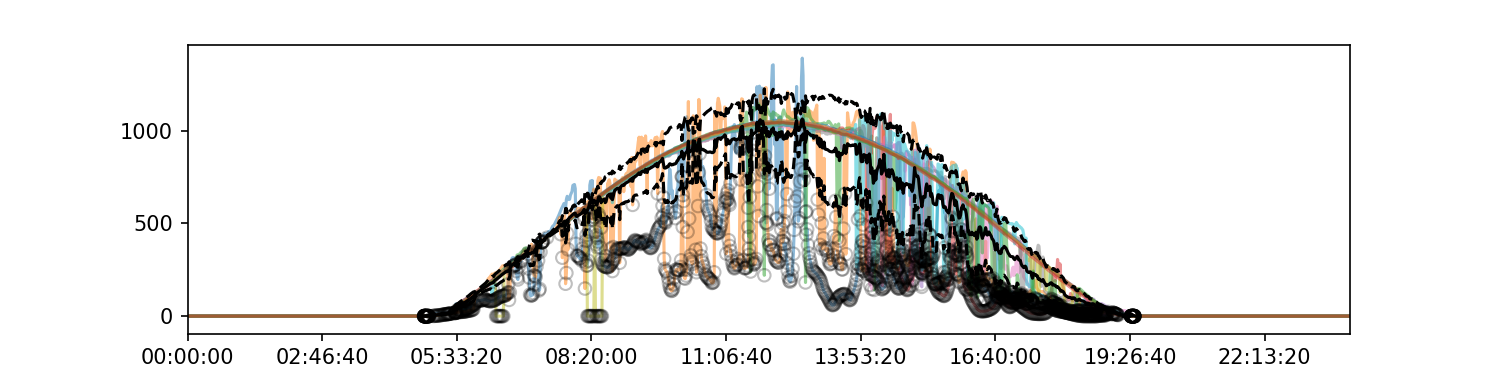

In [10]:
filtered_sample, components = preprocess.zscore_time_filter(sample, verbose=True, viz=True)

In [11]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clear_skies = rtc.get_clearsky(sample.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
    is_clear_pvlib = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

### Standard method

In [12]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect(sample, verbose=True)

In [13]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect(filtered_sample, verbose=True)

In [14]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8436 7379 7984


<IPython.core.display.Javascript object>


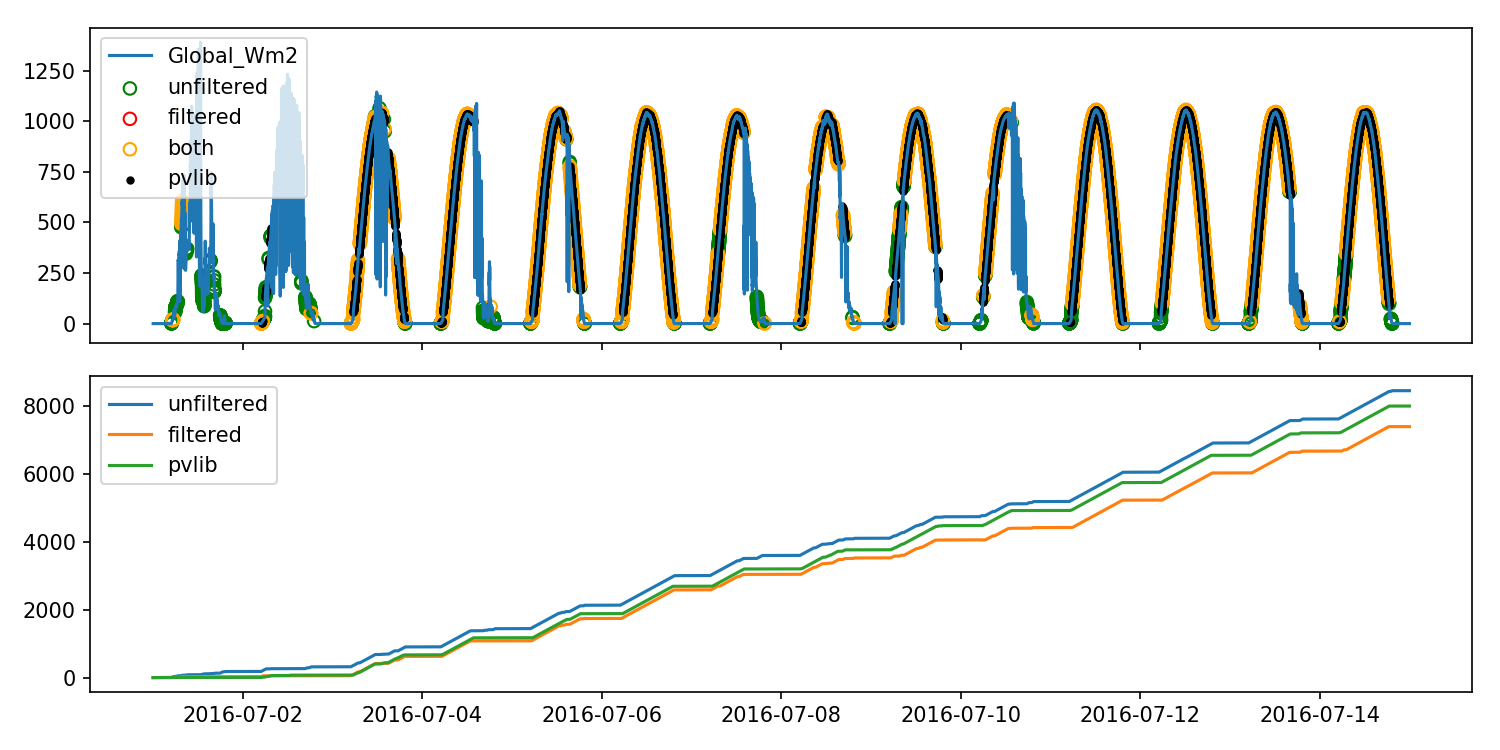

In [15]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

### Mean method

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, verbose=True)

In [17]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_meanval(filtered_sample, verbose=True)

In [18]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8111 6772 7984


<IPython.core.display.Javascript object>


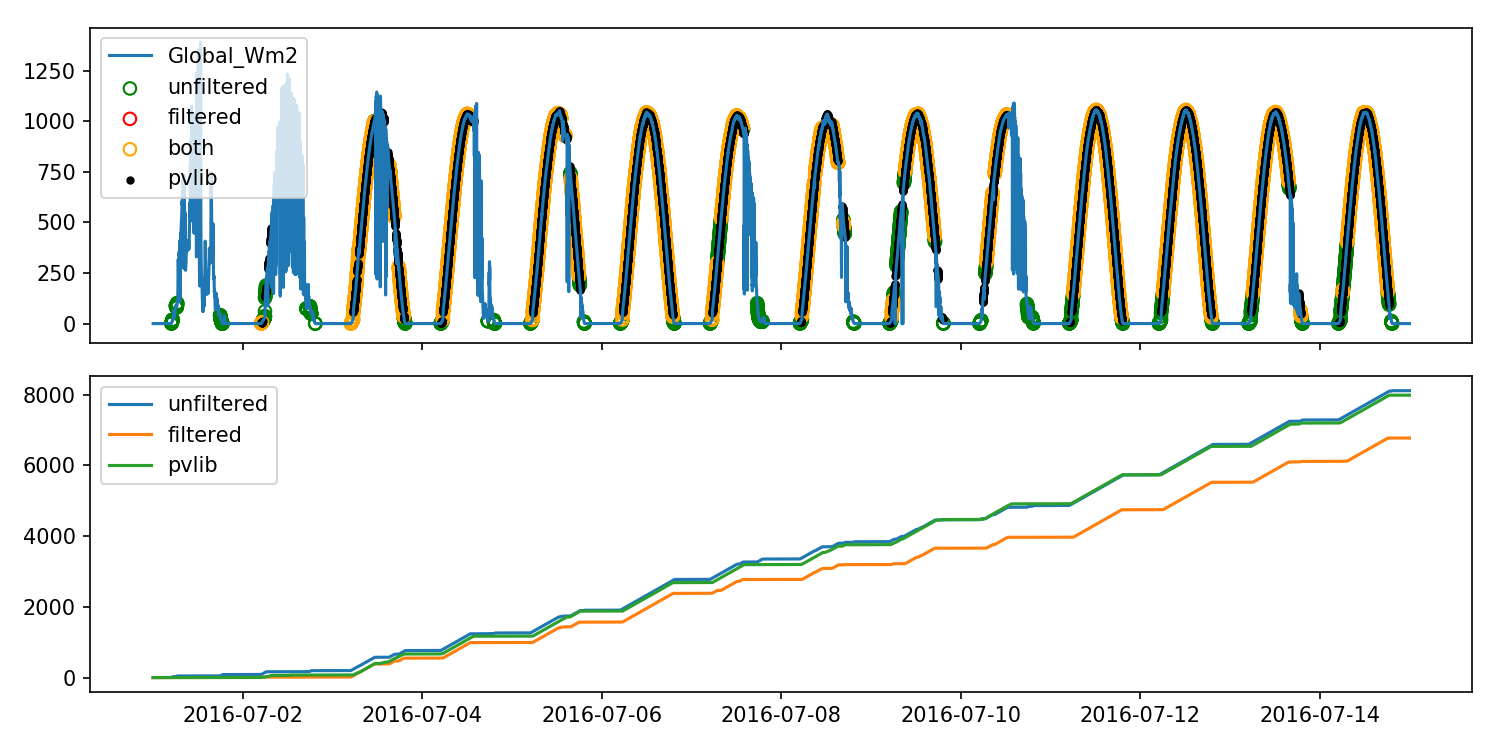

In [19]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

### Democratic method

In [20]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, verbose=True)

In [21]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_democratic(filtered_sample, verbose=True)

In [22]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

8096 7148 7984


<IPython.core.display.Javascript object>


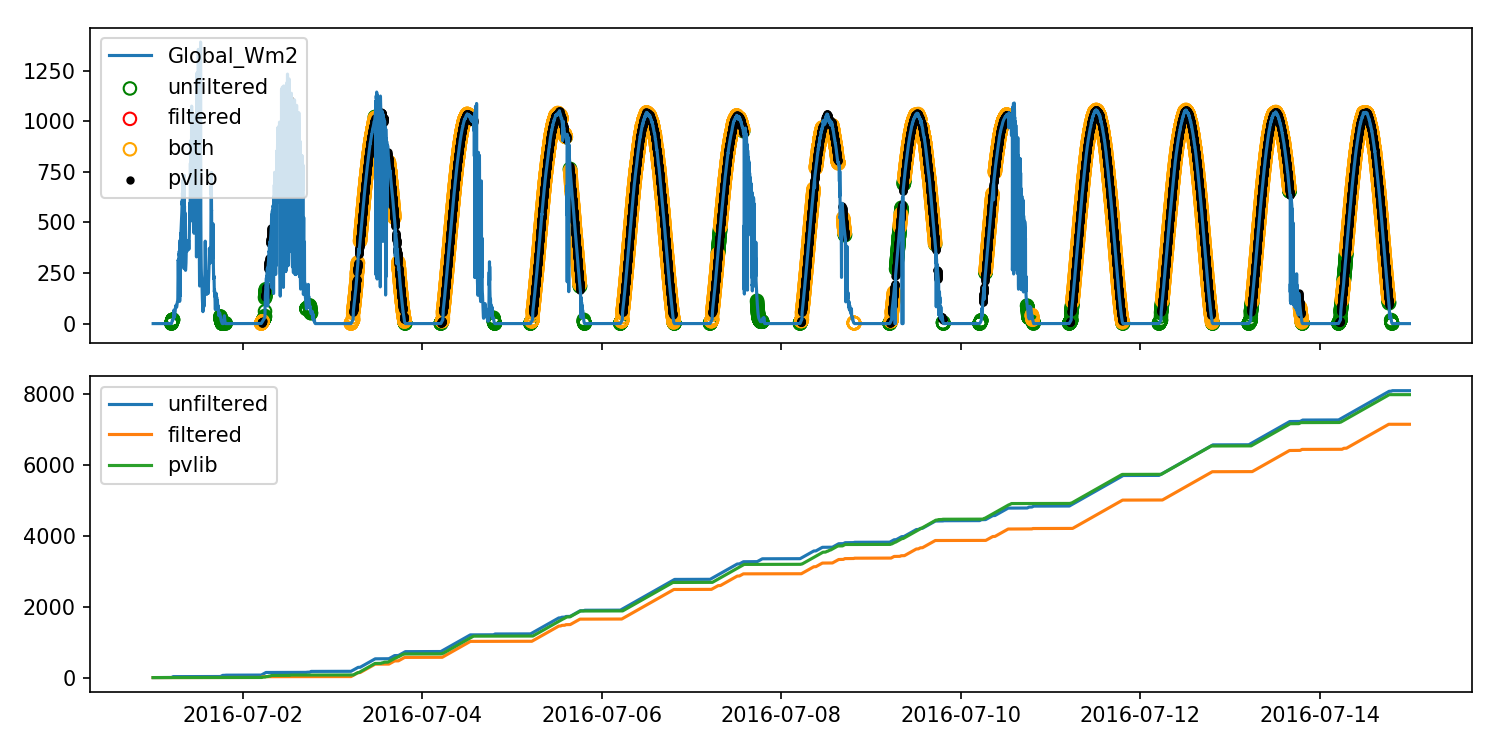

In [23]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

## SRRL

In [24]:
sample = srrl_data[(srrl_data.index >= '2014-01-01') & (srrl_data.index < '2014-01-15')]

<IPython.core.display.Javascript object>


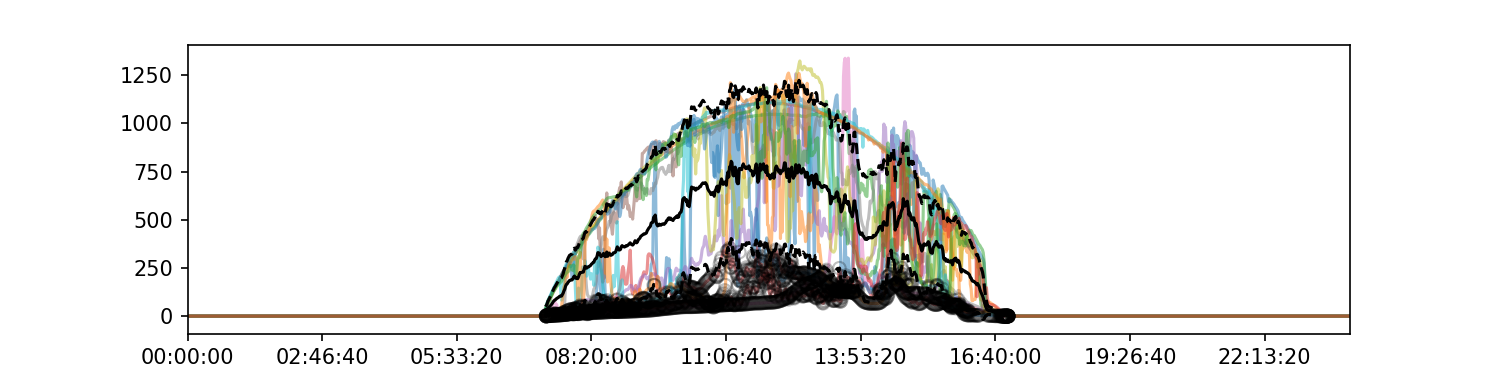

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    filtered_sample, components = preprocess.zscore_time_filter(sample, verbose=True, viz=True)

In [26]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    clear_skies = rtc.get_clearsky(sample.index)
    clear_skies = pd.Series(clear_skies['ghi'], index=sample.index)
    is_clear_pvlib = pvlib.clearsky.detect_clearsky(sample, clear_skies, sample.index, 10)

### Standard method

In [27]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect(sample, verbose=True)

In [28]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect(filtered_sample, verbose=True)

In [29]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

2928 1730 102


<IPython.core.display.Javascript object>


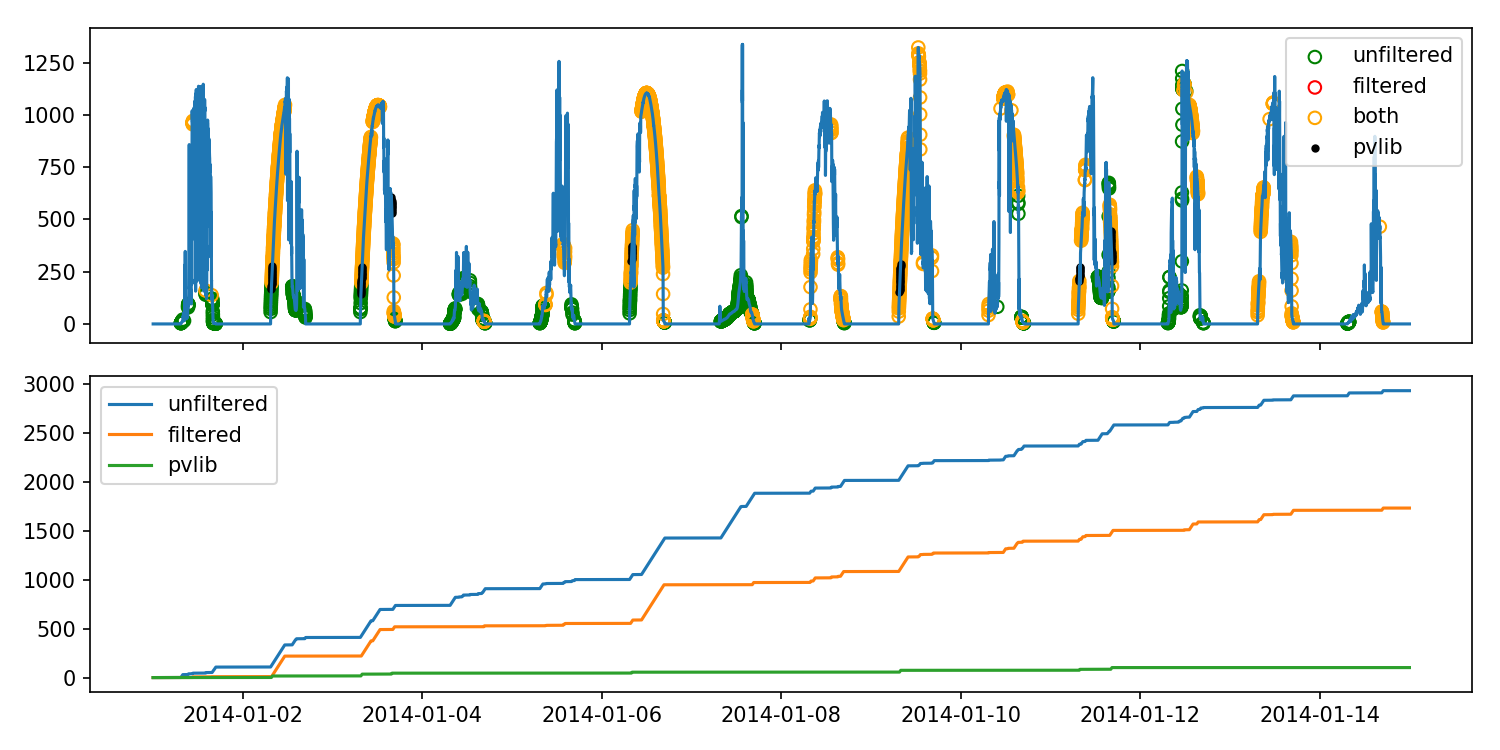

In [30]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

### Mean method

In [31]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_meanval(sample, verbose=True)

In [32]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_meanval(filtered_sample, verbose=True)

In [33]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

2527 1387 102


<IPython.core.display.Javascript object>


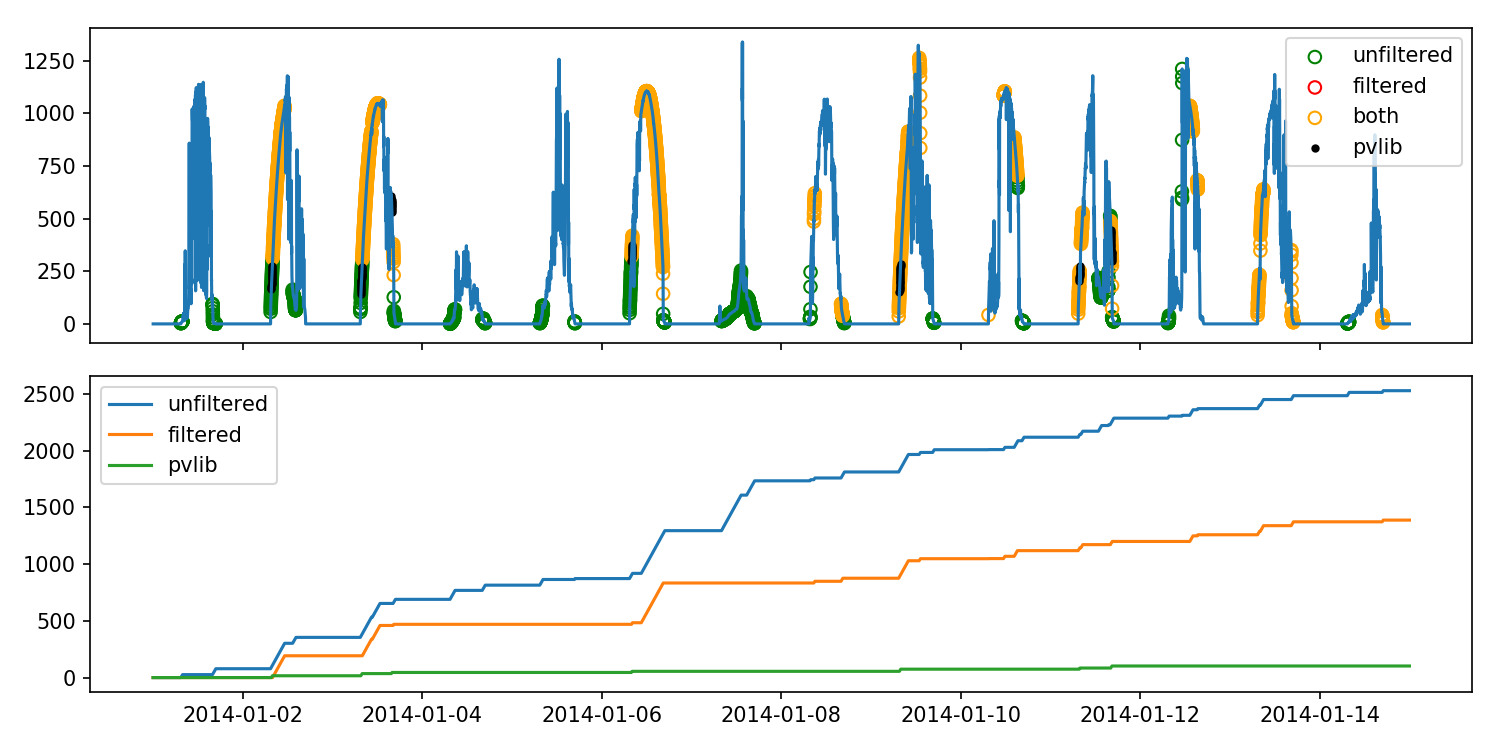

In [34]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

### Democratic method

In [35]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear, result = clearsky_detect_model_free.model_free_detect_democratic(sample, verbose=True)

In [36]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    is_clear_filtered, result_filtered = clearsky_detect_model_free.model_free_detect_democratic(filtered_sample, verbose=True)

In [37]:
print(len(is_clear[is_clear]), len(is_clear_filtered[is_clear_filtered]), len(is_clear_pvlib[is_clear_pvlib]))

2626 1490 102


<IPython.core.display.Javascript object>


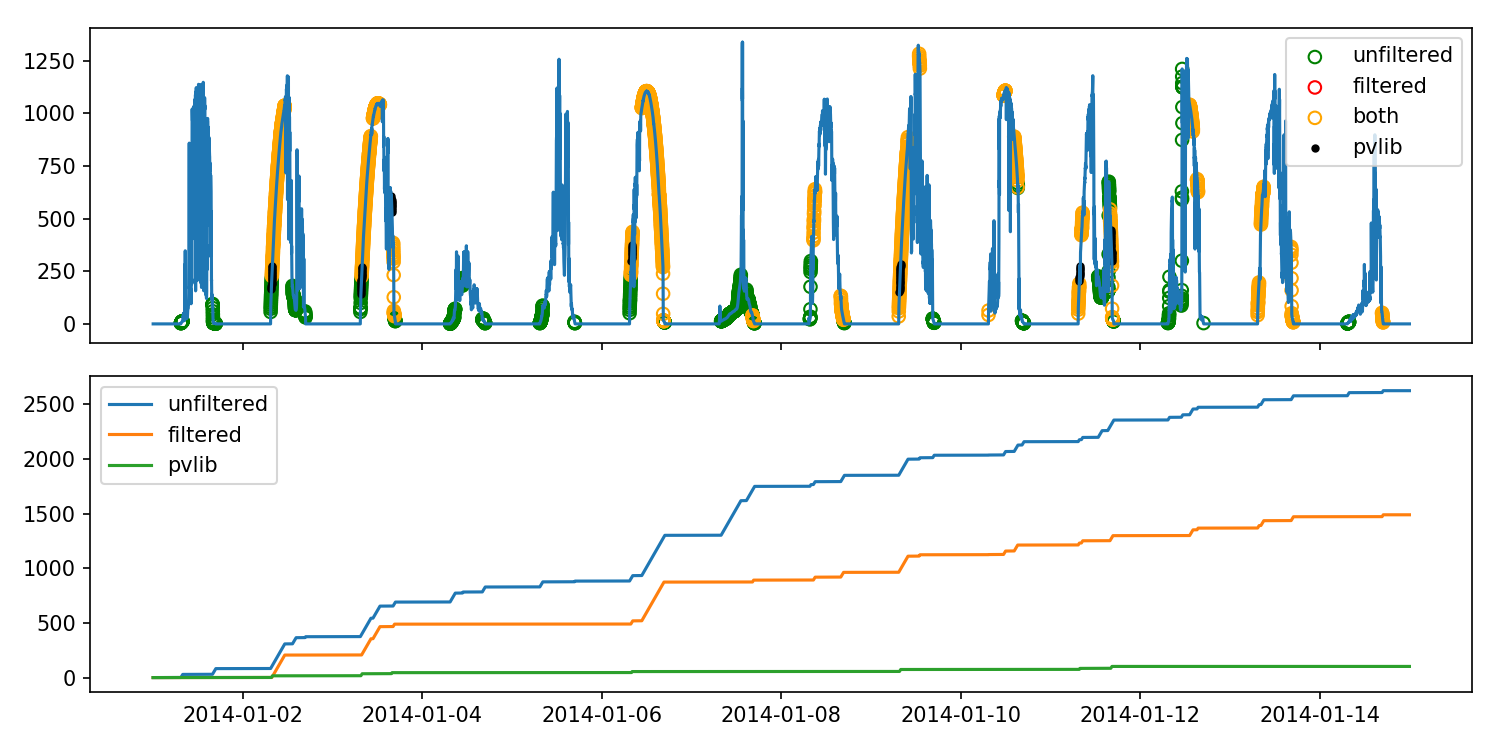

In [38]:
compare_plot(sample, is_clear, is_clear_filtered, is_clear_pvlib)

# Conclusion

The filtering based on avg - std does seem to work well for for this sample.  The filtering should be tested on more 'difficult' data, such as the SRRL data set which is what motivated this work in the first place (this will be added to this notebook before it is implemented fully).

As it stands right now, filtering sets individual time stamps to zero (as these days periods will then be labelled as obscured sky).  This has the side effect of actually generating clear sky times (which is seen by the red in the above plots).  In principle, filtering the data should not generate new periods of clear skies - it should always be a subset of the original clear sky days.  This issue will also be addressed.

# MISC